# 2. Veri ön işleme ve Özellik Mühendiliği 
* Churn tahmin modeline şekilde veriyi temizleme, dönüştürme modele hazır hale getirme işlemlerini içeriyor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


from churn_ml_project.data_loader import load_telco_data


In [2]:
data_path = '../data/dataset.csv' 
df = load_telco_data(data_path)

Veri seti başarıyla yüklendi. Boyut: (7043, 21)


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"], errors="coerce")

## Data Cleaning

In [5]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df[df["TotalCharges"].isnull()][["customerID", "tenure", "MonthlyCharges", "TotalCharges"]]

,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN
3331,7644-OMVMY,0,19.85,NaN
3826,3213-VVOLG,0,25.35,NaN
4380,2520-SGTTA,0,20.00,NaN
5218,2923-ARZLG,0,19.70,NaN
6670,4075-WKNIU,0,73.35,NaN


* tenure 0 yani bu müşteriler hiç hizmet almamış modelin öğrenebileceği bir durum olmadığı için bunları drop ediyorum

In [7]:
df.dropna(subset=["TotalCharges"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.isnull().sum().sum()

0

In [9]:
df.duplicated().sum()

0

## Aykırı Değer Analizi

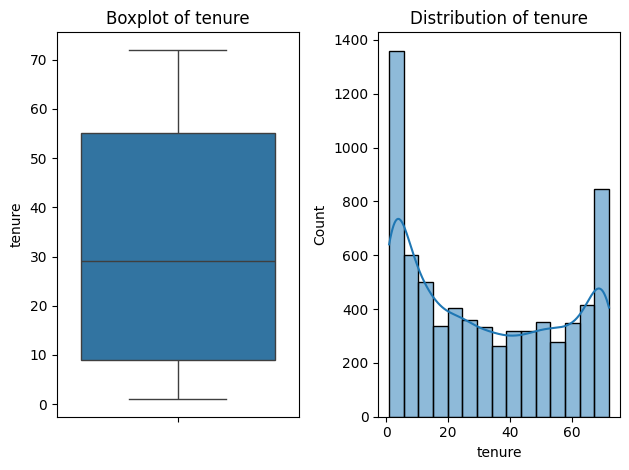


tenure değişkeninde 0 aykırı değer var.


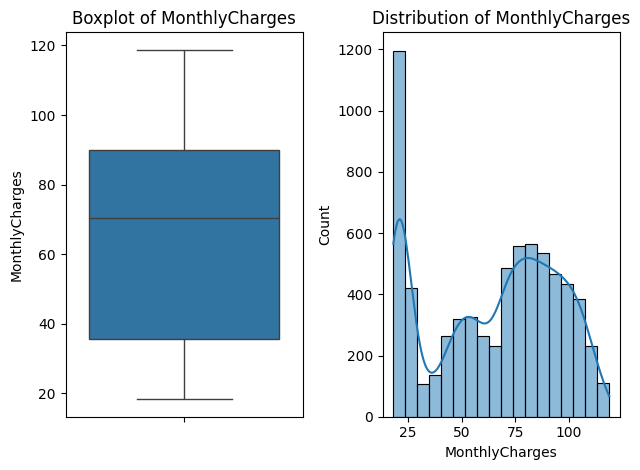


MonthlyCharges değişkeninde 0 aykırı değer var.


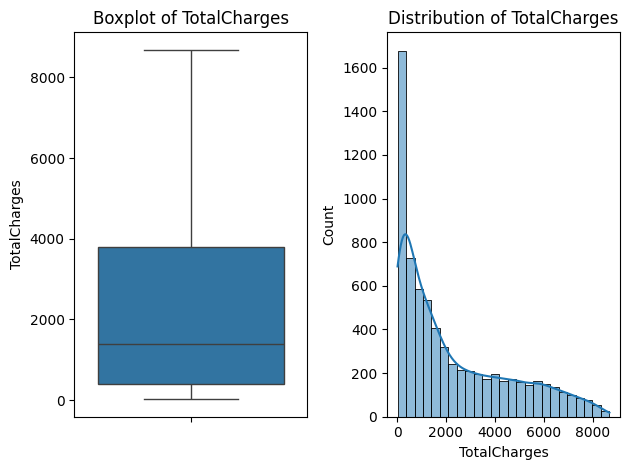


TotalCharges değişkeninde 0 aykırı değer var.


In [10]:
num_cols= ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    plt.subplot(1,2,1)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col}")

    plt.subplot(1,2,2)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

    # alt sınır ve üst sınırları belirleyelim q3-q1 ile IQR hesaplayalım
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"\n{col} değişkeninde {len(outliers)} aykırı değer var.")

### Encoding 

* Binary kategiler için label encoding
* çoklu kategorik değişken one hot encoding


In [11]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.append("SeniorCitizen")
categorical_cols.remove("customerID")

In [12]:
for col in categorical_cols:
    print(f"{col} unique values:\n{df[col].value_counts(dropna=False)}\n")


gender unique values:
gender
Male      3549
Female    3483
Name: count, dtype: int64

Partner unique values:
Partner
No     3639
Yes    3393
Name: count, dtype: int64

Dependents unique values:
Dependents
No     4933
Yes    2099
Name: count, dtype: int64

PhoneService unique values:
PhoneService
Yes    6352
No      680
Name: count, dtype: int64

MultipleLines unique values:
MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64

InternetService unique values:
InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

OnlineSecurity unique values:
OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64

OnlineBackup unique values:
OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64

DeviceProtection unique values:
DeviceProtection
No              

* Binary Değişkenler (label encoding): (0-1)
     - gender, Partner, Dependents, PhoneServic, PaperlessBilling, Churn, SeniorCitizen
* One hot encoding : 
     - InternetService, Contract, PaymentMethod, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSuppor, StreamingTV, StreamingMovies 

In [13]:
# label encoding 
binary_map= {"Yes":1, "No":0 , "Male":1, "Female":0}

df["gender"]= df["gender"].map(binary_map)
df["Partner"]= df["Partner"].map(binary_map)
df["Dependents"]= df["Dependents"].map(binary_map)
df["PhoneService"]= df["PhoneService"].map(binary_map)
df["PaperlessBilling"]=df["PaperlessBilling"].map(binary_map)
df["Churn"]= df["Churn"].map(binary_map)
df["SeniorCitizen"]=df["SeniorCitizen"].astype("int")

In [14]:
one_hot_cols = ["InternetService", "Contract", "PaymentMethod", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection","TechSupport", "StreamingTV", "StreamingMovies"]

df= pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


In [15]:
print(f"Veri seti boyutu: {df.shape}")
df.head()


Veri seti boyutu: (7032, 32)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,False,True,False,False,False,False,False,False,False,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,False,False,False,True,False,False,False,False,False,False
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,False,True,False,False,False,False,False,False,False,False
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,False,False,False,True,False,True,False,False,False,False
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,False,False,False,False,False,False,False,False,False,False


In [16]:
print("Sayısal veri türleri:")
print(df.dtypes.value_counts())

Sayısal veri türleri:
bool       21
int64       7
float64     2
object      1
int32       1
Name: count, dtype: int64


In [17]:
print("Sütunlar:")
print(df.columns.tolist())

Sütunlar:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes']


In [18]:
y = df["Churn"]
X= df.drop(["customerID", "Churn"], axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_std=X.copy()
X_minmax=X.copy()

scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X_std)

scaler_minmax = MinMaxScaler()
X_scaled_minmax = scaler_minmax.fit_transform(X_minmax)

3 tane x oluşturdum ölçekleme gerekmeyen modeller için , min max ölçekleme ve standart ölçekleme bunları modellere göre ayarlaaycağım

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_scaled_std, y, test_size=0.2, random_state=42, stratify=y)

X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_scaled_minmax, y, test_size=0.2, random_state=42, stratify=y)

## Model Training ve Değerlendirme

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [27]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score)
                             
def evaluate_clf(y_true, y_pred, y_prob=None):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return acc, prec, rec, f1, auc

In [28]:
def evaluate_models(models_dict, y_train, y_test):
    rows = []
    for name, (mdl, Xtr, Xte) in models_dict.items():
        mdl.fit(Xtr, y_train)
        y_pred = mdl.predict(Xte)
        y_prob = mdl.predict_proba(Xte)[:, 1] if hasattr(mdl, "predict_proba") else None
        acc, prec, rec, f1, auc = evaluate_clf(y_test, y_pred, y_prob)
        rows.append([name, acc, prec, rec, f1, auc])
    cols = ["Model", "Acc", "Prec", "Recall", "F1", "ROC-AUC"]
    return pd.DataFrame(rows, columns=cols).sort_values("F1", ascending=False)

In [29]:

base_models = {
    "LogReg":  (LogisticRegression(max_iter=1000, random_state=42), X_train_std, X_test_std),
    "SVM":     (SVC(probability=True), X_train_std, X_test_std),
    "KNN":     (KNeighborsClassifier(), X_train_std, X_test_std),

    "DecisionTree":     (DecisionTreeClassifier(random_state=42), X_train, X_test),
    "RandomForest":     (RandomForestClassifier(random_state=42), X_train, X_test),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), X_train, X_test),
    "AdaBoost":         (AdaBoostClassifier(random_state=42), X_train, X_test),
    "XGBoost":          (XGBClassifier(n_jobs=-1, random_state=42), X_train, X_test),
    "CatBoost":         (CatBoostClassifier(verbose=False, random_state=42),X_train, X_test)}


In [30]:
baseline_report = evaluate_models(base_models, y_train, y_test)
baseline_report


,Model,Acc,Prec,Recall,F1,ROC-AUC
0,LogReg,0.803838,0.647590,0.574866,0.609065,0.835688
5,GradientBoosting,0.795309,0.637821,0.532086,0.580175,0.840659
7,XGBoost,0.778252,0.589080,0.548128,0.567867,0.819647
6,AdaBoost,0.795309,0.648276,0.502674,0.566265,0.840830
4,RandomForest,0.793888,0.644828,0.500000,0.563253,0.817175
8,CatBoost,0.782516,0.609677,0.505348,0.552632,0.829470
1,SVM,0.786780,0.625850,0.491979,0.550898,0.790907
2,KNN,0.754797,0.538874,0.537433,0.538153,0.767369
3,DecisionTree,0.709311,0.453333,0.454545,0.453939,0.628003
